# Machine Learning Applied to Data Drift Detection

When randomly splitting a dataset into two subsets—set 0 and set 1—we do not expect to find significant differences in their distributions, except for minor random variations. This is because both sets are randomly sampled from the same original dataset.

If we train a classification model (e.g., Random Forest) using the **Set** variable as the target and the other columns as features, we would expect the model's accuracy to be approximately **50%**. Since the subsets share the same distribution, the model should not be able to distinguish between them effectively, resulting in performance similar to random guessing.

## Experiment

In [16]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [13]:
def rebalance(data):
    """
    Resample data to keep balance between target classes.

    The function uses the resample function to downsample the minority class to match the majority class.

    Args:
        data (pd.DataFrame): DataFrame

    Returns:
        (pd.DataFrame): balanced DataFrame
    """
    churn_0 = data[data["Exited"] == 0]
    churn_1 = data[data["Exited"] == 1]
    if len(churn_0) > len(churn_1):
        churn_maj = churn_0
        churn_min = churn_1
    else:
        churn_maj = churn_1
        churn_min = churn_0
    churn_maj_downsample = resample(
        churn_maj, n_samples=len(churn_min), replace=False, random_state=1234
    )

    return pd.concat([churn_maj_downsample, churn_min])

def preprocess(df):
    """
    Preprocess data for training.

    Args:
        df (pd.DataFrame): DataFrame with features and target variables

    Returns:
        pd.DataFrame: preprocessed DataFrame
    """
    filter_feat = [
        "CreditScore",
        "Geography",
        "Gender",
        "Age",
        "Tenure",
        "Balance",
        "NumOfProducts",
        "HasCrCard",
        "IsActiveMember",
        "EstimatedSalary",
        "Exited",
    ]
    data = df.loc[:, filter_feat]
    data_balanced = rebalance(data=data)
    # shuffle and return
    return data_balanced.sample(frac=1, random_state=42)

Open the dataset:

In [4]:
data_folder = "../data"
data_file = "Churn_Modelling.csv"
file_path = os.path.join(data_folder, data_file)

In [5]:
raw_df = pd.read_csv(file_path)
df = preprocess(raw_df)
print(f"Data Shape: {df.shape}")
df.head()

(4074, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1456,639,Spain,Male,28,8,0.00,2,1,0,126561.07,0
81,777,France,Female,32,2,0.00,1,1,0,136458.19,1
6383,594,France,Male,36,6,153880.15,1,0,0,135431.72,0
5774,706,Germany,Male,31,1,117020.08,2,1,0,54439.53,0
3105,678,France,Female,28,4,0.00,2,1,1,144423.17,1


**Randomly** distribute the dataset rows between the sets **set 0** and **set 1**.

In [6]:
df["Set"] = random.choices([0, 1], k=len(df))

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Set
1456,639,Spain,Male,28,8,0.00,2,1,0,126561.07,0,0
81,777,France,Female,32,2,0.00,1,1,0,136458.19,1,1
6383,594,France,Male,36,6,153880.15,1,0,0,135431.72,0,1
5774,706,Germany,Male,31,1,117020.08,2,1,0,54439.53,0,0
3105,678,France,Female,28,4,0.00,2,1,1,144423.17,1,0


Separate data between **features** and **target**:

In [7]:
X = df.drop("Set", axis=1)
y = df["Set"]

Create the training and testing set:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1912
)

Prepare the data:

In [9]:
cat_cols = ["Geography", "Gender"]
num_cols = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "HasCrCard",
    "IsActiveMember",
    "EstimatedSalary",
]

col_transf = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
    remainder="passthrough",
)

X_train = col_transf.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=col_transf.get_feature_names_out())

X_test = col_transf.transform(X_test)
X_test = pd.DataFrame(X_test, columns=col_transf.get_feature_names_out())

**Create** and **train** the model:

In [10]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

Check accuracy and confusion matrix:

In [11]:
y_pred = clf.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")

Accuracy score: 0.49


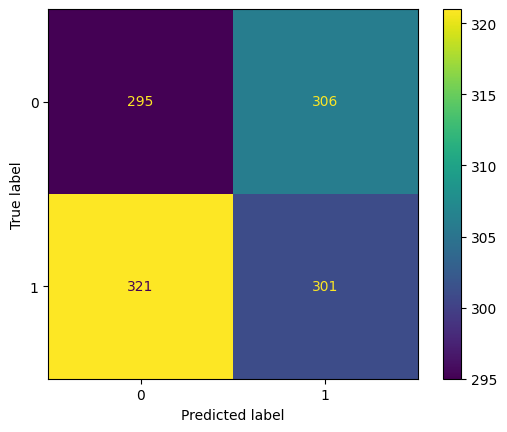

In [12]:
conf_mat = confusion_matrix(y_test, y_pred, labels=clf.classes_)
conf_mat_disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat, display_labels=clf.classes_
)
conf_mat_disp.plot()

As observed, the model's performance was close to 50%, indicating no significant evidence of data drift in the dataset. This result occurs because the distributions between the two subsets are similar, showing that the data remains consistent across both sets.


## Application

Let’s extend this concept to a real-world scenario. Imagine we have two datasets collected at different points in time, such as Set January and Set April, with a few months separating their collection.

What would happen if we repeated the experiment?

If there is **no data drift** between the two sets, the model’s accuracy would remain around 50%, as the feature distributions would still be similar, making it difficult for the model to distinguish between the two sets. However, if **data drift exists**, the model’s accuracy would increase, as it would begin to detect patterns or changes in the feature distributions, allowing it to more confidently predict which set the data belongs to. This rise in accuracy would signal a shift in the data over time.

In practice, depending on the specific application and other monitoring metrics (such as business metrics), we can define an accuracy threshold that warrants concern and action. If the accuracy exceeds this predefined threshold, it may indicate significant data drift that could impact the performance of machine learning models or business processes, prompting the need for further investigation or corrective measures.

## New Experiment

In [32]:
# Set distributions (no data drift)
# avg_january = 0.0
# std_january = 1.0
# avg_april = 0.0
# std_april = 1.0

# Set distributions (with "data drift")
avg_january = 0.0
std_january = 1.0
avg_april = 0.75
std_april = 1.2

Create dataset from distributions:

In [33]:
# Generate data from two distributions
np.random.seed(1234)
data_jan = np.random.normal(loc=avg_january, scale=std_january, size=1000)
data_apr = np.random.normal(loc=avg_april, scale=std_april, size=1000)

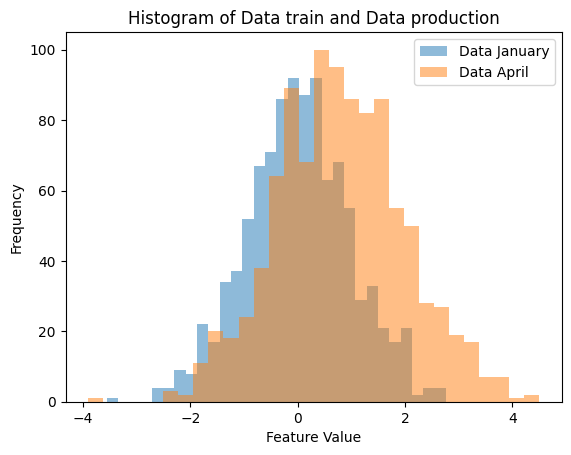

In [34]:
# Plot histograms of the two distributions
plt.hist(data_jan, bins=30, alpha=0.5, label="Data January")
plt.hist(data_apr, bins=30, alpha=0.5, label="Data April")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data train and Data production")
plt.legend()
plt.savefig("../img/ks_test_ex.png")
plt.show()

Transform into a Dataframe with all data:

In [28]:
df_jan = pd.DataFrame({"feature": data_jan, "set": [0] * len(data_jan)})
df_jan.head()

df_apr = pd.DataFrame({"feature": data_apr, "set": [1] * len(data_jan)})
df_apr.head()

# Concatenate DataFrames
df_sim = pd.concat([df_jan, df_apr], axis=0)
df_sim

,feature,set
0,0.471435,0
1,-1.190976,0
2,1.432707,0
3,-0.312652,0
4,-0.720589,0
...,...,...
995,1.509095,1
996,3.166058,1
997,1.687755,1
998,3.326582,1


Create the training and testing set:

In [29]:
X = df_sim.drop("set", axis=1)
y = df_sim["set"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1912
)

Train the classifier:

In [30]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

Check it's performance:

In [35]:
y_pred = clf.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")

Accuracy score: 0.65


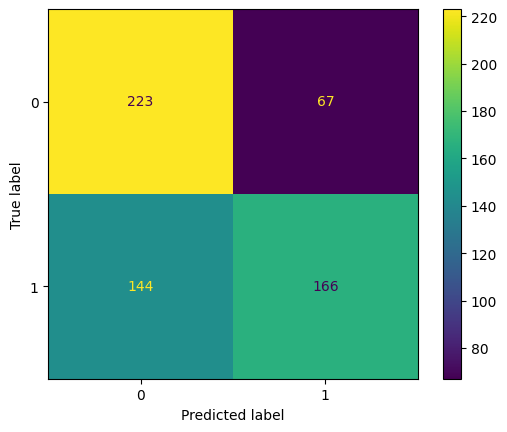

In [36]:
conf_mat = confusion_matrix(y_test, y_pred, labels=clf.classes_)
conf_mat_disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat, display_labels=clf.classes_
)
conf_mat_disp.plot()

And in this way, we saw how to use ML to identify the presence of data drift in datasets used in ML!